In [1]:
import json
import numpy as np
from pathlib import Path
import time
import sys, os, contextlib
import matplotlib.pyplot as plt

import xobjects as xo
import xtrack as xt
import xcoll as xc
import xpart as xp
from madxtools.particles import *

In [2]:
num_part = int(5000)


# Make a transfer line
# ====================
k_qf_1 = 0.32730047
k_qd_2 = -0.36102915
k_qf_3 = 0.32789126
k_qd_4 = -0.1991137
l_quad = 2

elements = [
            xt.Quadrupole(k1=k_qf_1, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_2, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qf_3, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_4, length=l_quad),
            xt.Drift(length=89.),
            xt.Marker()
           ]
element_names = ["QF1", "drift_1", "QD2", "drift_2", "QF3", "drift_3", "QD4",
                 "drift_4", "END"]
particle_ref = xp.Particles(energy0=24.e9)
line = xt.Line(elements=elements, element_names=element_names, particle_ref=particle_ref)

In [3]:
# Add air regions
# ===============
X0_air = 301
air = xc.Material(radiation_length=X0_air, name="Air (1 atm 20C)")

line.insert_element(element=xc.EverestBlock(length=20, material=air), name="Air 1", at_s=40)
# line.insert_element(element=xc.EverestBlock(length=10, material=air), name="Air 2", at_s=50)


# Add monitors
# ============
mon_air_1_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_1_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
line.insert_element(element=mon_air_1_s, name="monitor air 1 start", at_s=40)
line.insert_element(element=mon_air_1_e, name="monitor air 1 end", at_s=60)
# line.insert_element(element=mon_air_2_s, name="monitor air 2 start", at_s=50)
# line.insert_element(element=mon_air_2_e, name="monitor air 2 end", at_s=60)


Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [4]:
# Generate an initial distribution of particles
# =============================================
line.build_tracker()

# Scattering need to be disabled to be able to twiss
line["Air 1"]._tracking = False
# line["Air 2"]._tracking = False

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
dx0 = 0.13
dy0 = 0.0
dpx0 = 0.02
dpy0 = 0.0
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='4d', start="QF1", end="END", init=tw_init)

nemitt_x = 7.639770207283603e-06
nemitt_y = 3.534081877201574e-06
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()

# re-enable scattering
line["Air 1"]._tracking = True
# line["Air 2"]._tracking = True



# Track and store emittance at every turn
# =======================================
def calculate_nemitt(part):
    cov_x = np.cov(part.x, part.px)
    cov_y = np.cov(part.y, part.py)
    nemitt_x = part.gamma0[0]*np.sqrt(cov_x[0,0]*cov_x[1,1]-cov_x[1,0]*cov_x[0,1])
    nemitt_y = part.gamma0[0]*np.sqrt(cov_y[0,0]*cov_y[1,1]-cov_y[1,0]*cov_y[0,1])
    return nemitt_x, nemitt_y

def calculate_nemitt_monitor(mon):
    result = []
    for turn in range(mon.x.shape[1]):
        cov_x = np.cov([x[turn] for x in mon.x], [px[turn] for px in mon.px])
        cov_y = np.cov([y[turn] for y in mon.y], [py[turn] for py in mon.py])
        nemitt_x = part.gamma0[0]*np.sqrt(cov_x[0,0]*cov_x[1,1]-cov_x[1,0]*cov_x[0,1])
        nemitt_y = part.gamma0[0]*np.sqrt(cov_y[0,0]*cov_y[1,1]-cov_y[1,0]*cov_y[0,1])
        result = [*result, [nemitt_x, nemitt_y]]
    return result

ex, ey = calculate_nemitt(part)
nemitt_x = [ex]
nemitt_y = [ey]

line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

ex, ey = calculate_nemitt_monitor(mon_air_1_s)[0]
nemitt_x.append(ex)
nemitt_y.append(ey)
ex, ey = calculate_nemitt_monitor(mon_air_1_e)[0]
nemitt_x.append(ex)
nemitt_y.append(ey)
# ex, ey = calculate_nemitt_monitor(mon_air_2_s)[0]
# nemitt_x.append(ex)
# nemitt_y.append(ey)
# ex, ey = calculate_nemitt_monitor(mon_air_2_e)[0]
# nemitt_x.append(ex)
# nemitt_y.append(ey)
ex, ey = calculate_nemitt(part)
nemitt_x.append(ex)
nemitt_y.append(ey)


# # Plot the result
# # ===============
# _, ax = plt.subplots(figsize=(6,4))
# s = [0, 20, 30, 50, 60, 100]
# ax.plot(s, 1.e6*np.array(nemitt_x), label='H')
# ax.plot(s, 1.e6*np.array(nemitt_y), label='V')
# ax.set_ylabel(r"$\epsilon\; [\mu\mathrm{m}]$")
# ax.set_xlabel("s [m]")
# ax.legend()

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [5]:
# import pandas as pd
# d = {'s': [0, 20, 30, 50, 60, 100], 'nemitt_x': nemitt_x, 'nemitt_y': nemitt_y}
# df = pd.DataFrame(data=d)

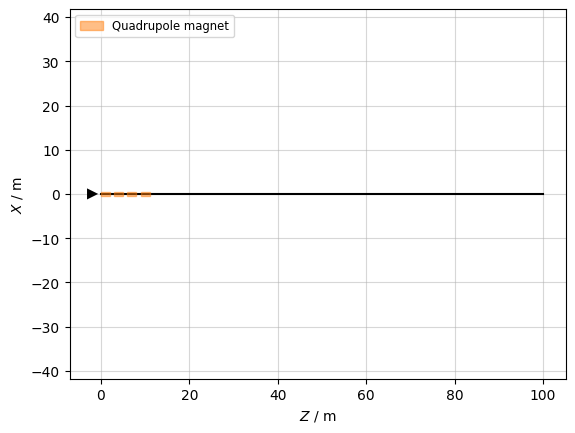

In [6]:
# Plot ring geometry using Xplt (credits P. Niedermayer)
import xplt
# Compute survey
sv = line.survey()
xplt.FloorPlot(sv, line)
plt.legend(fontsize='small', loc='upper left')

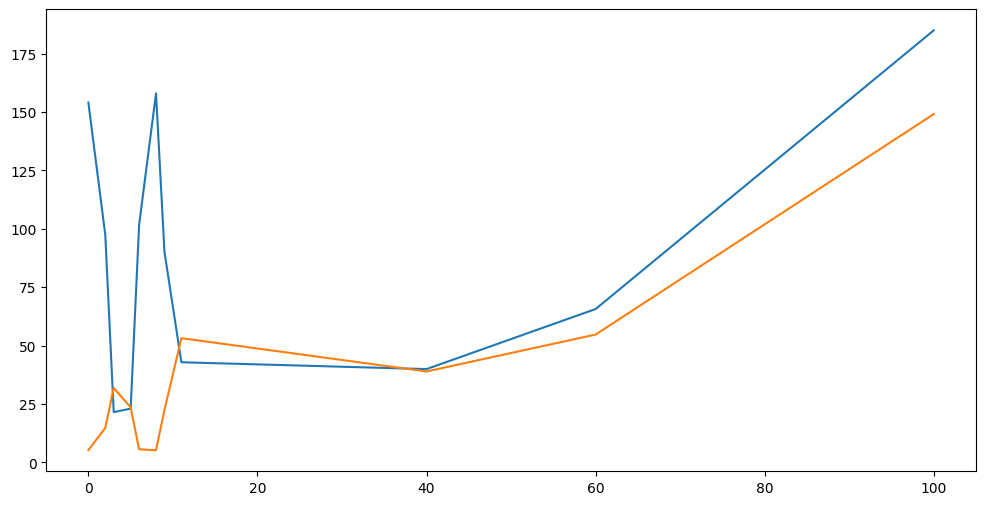

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tw.s, tw.betx)
ax.plot(tw.s, tw.bety)

In [8]:
s_list = line.record_last_track.s[0,:]
beta_list = []
for i in range(len(line.record_last_track.s[0,:])):
    x = line.record_last_track.x[:,i]
    px = line.record_last_track.px[:,i]
    beta, alpha, gamma, epsilon = twiss_parameters_from_distribution(x, px)
    beta_list.append(beta)

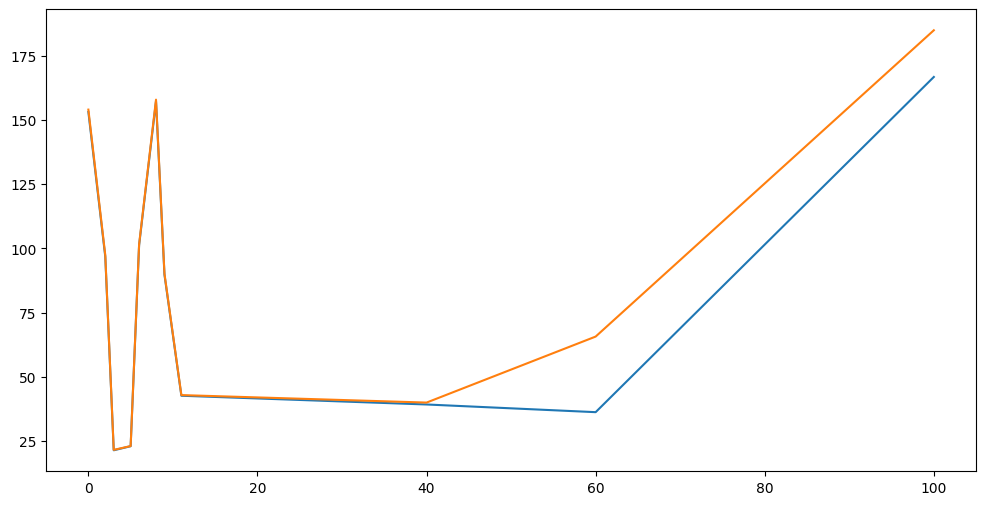

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tw.s, beta_list)
ax.plot(tw.s, tw.betx)

Text(0, 0.5, 'y [m]')

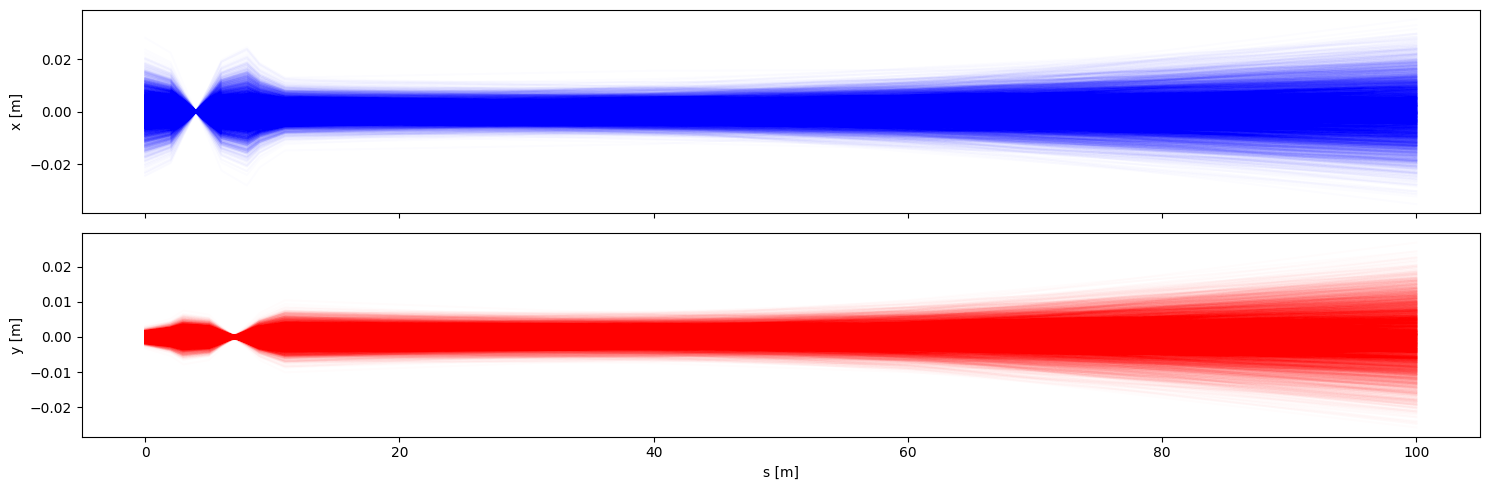

In [10]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax[0].plot(line.record_last_track.s[i], line.record_last_track.x[i], color='blue', alpha=0.01);
    ax[1].plot(line.record_last_track.s[i], line.record_last_track.y[i], color='red', alpha=0.01);

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

Text(0, 0.5, 'y [m]')

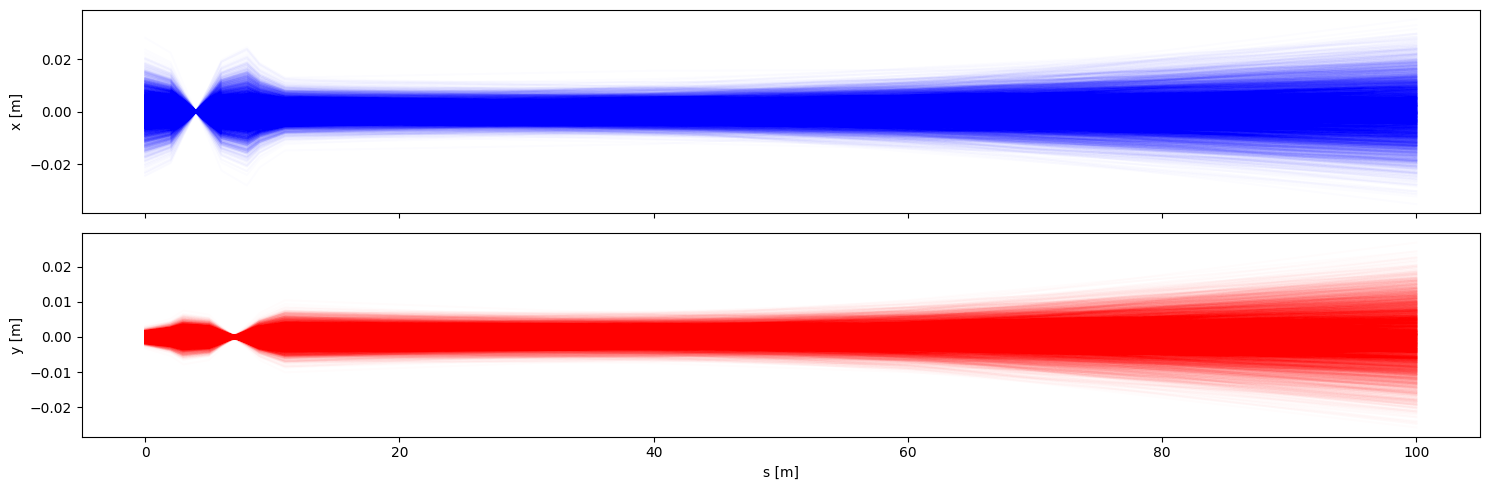

In [11]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax[0].plot(tw.s, line.record_last_track.x[i], color='blue', alpha=0.01);
    ax[1].plot(tw.s, line.record_last_track.y[i], color='red', alpha=0.01);

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_760/137312752.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma')


Text(0, 0.5, 'y [m]')

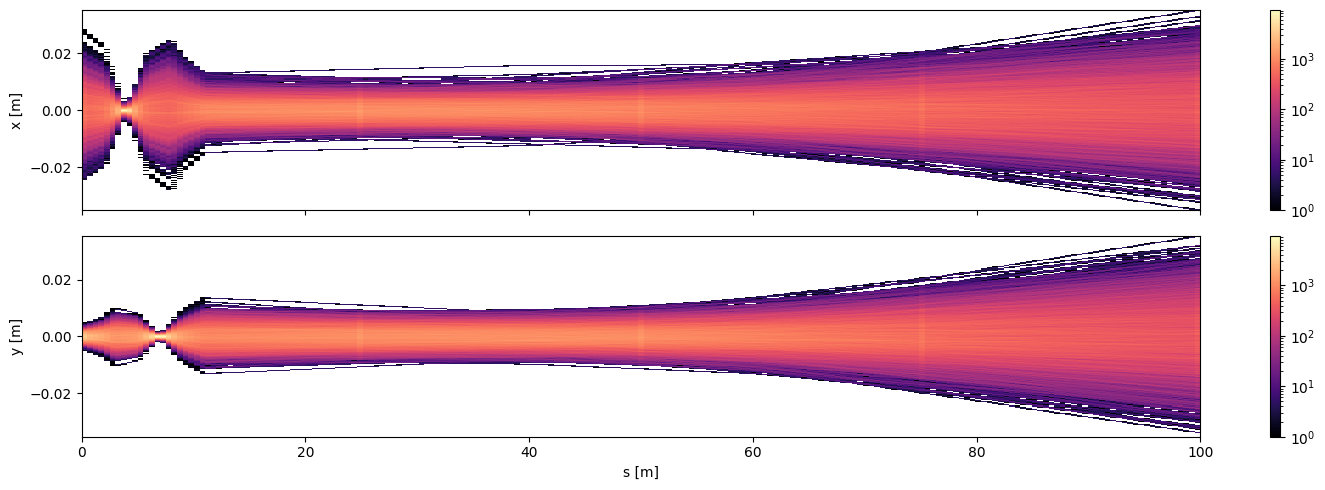

In [12]:
import matplotlib.colors as colors
from scipy.interpolate import interp1d

fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

# Create arrays for s, x, and y values
s_values = []
x_values = []
y_values = []

# Flatten the list of arrays to a single array
s_all = np.concatenate(line.record_last_track.s)

# Find the maximum value in the flattened array
s_max = s_all.max()

# Define the new s grid
s_grid = np.linspace(0, s_max, 1000)

# Loop over all particles and append their interpolated x and y values to the arrays
for i in range(len(line.record_last_track.s)):
    s = line.record_last_track.s[i]
    x = line.record_last_track.x[i]
    y = line.record_last_track.y[i]

    # Create interpolation functions for x and y as a function of s
    x_interp = interp1d(s, x, kind='linear', fill_value='extrapolate')
    y_interp = interp1d(s, y, kind='linear', fill_value='extrapolate')

    # Evaluate the interpolation functions on the s grid and append to the arrays
    s_values.extend(s_grid)
    x_values.extend(x_interp(s_grid))
    y_values.extend(y_interp(s_grid))

# Convert the lists to numpy arrays
s_values = np.array(s_values)
x_values = np.array(x_values)
y_values = np.array(y_values)


# Create 2D histograms for x and y
bins = 200
hx, xedges, yedges = np.histogram2d(s_values, x_values, bins=[np.linspace(0, max(s_values), bins), np.linspace(-max(x_values), max(x_values), bins)])
hy, _, _ = np.histogram2d(s_values, y_values, bins=[np.linspace(0, max(s_values), bins), np.linspace(-max(y_values), max(y_values), bins)])

# Define the color scale min and max values
color_min = 1
color_max_x = np.max(hx)
color_max_y = np.max(hy)

# Create the log color normalizer
cmap = plt.cm.get_cmap('magma')
norm_x = colors.LogNorm(vmin=color_min, vmax=color_max_x)
norm_y = colors.LogNorm(vmin=color_min, vmax=color_max_y)

# Draw the density plots
pcm = ax[0].pcolormesh(xedges, yedges, hx.T, cmap=cmap, norm=norm_x)
fig.colorbar(pcm, ax=ax[0])
pcm = ax[1].pcolormesh(xedges, yedges, hy.T, cmap=cmap, norm=norm_y)
fig.colorbar(pcm, ax=ax[1])

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

# ax[0].set_ylim(-0.04, 0.04)
# ax[1].set_ylim(-0.04, 0.04)

# Export to pickle

In [13]:
import pickle
with open('xsuite_track.p', 'wb') as handle:
    pickle.dump(line.record_last_track, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('xsuite_part.p', 'wb') as handle:
    pickle.dump(part, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('xsuite_line.p', 'wb') as handle:
    pickle.dump(line, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('xsuite_tw.p', 'wb') as handle:
    pickle.dump(tw.s, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('xsuite_emitt.p', 'wb') as handle:
#     pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Beam size along the line

Text(0, 0.5, 'y [m]')

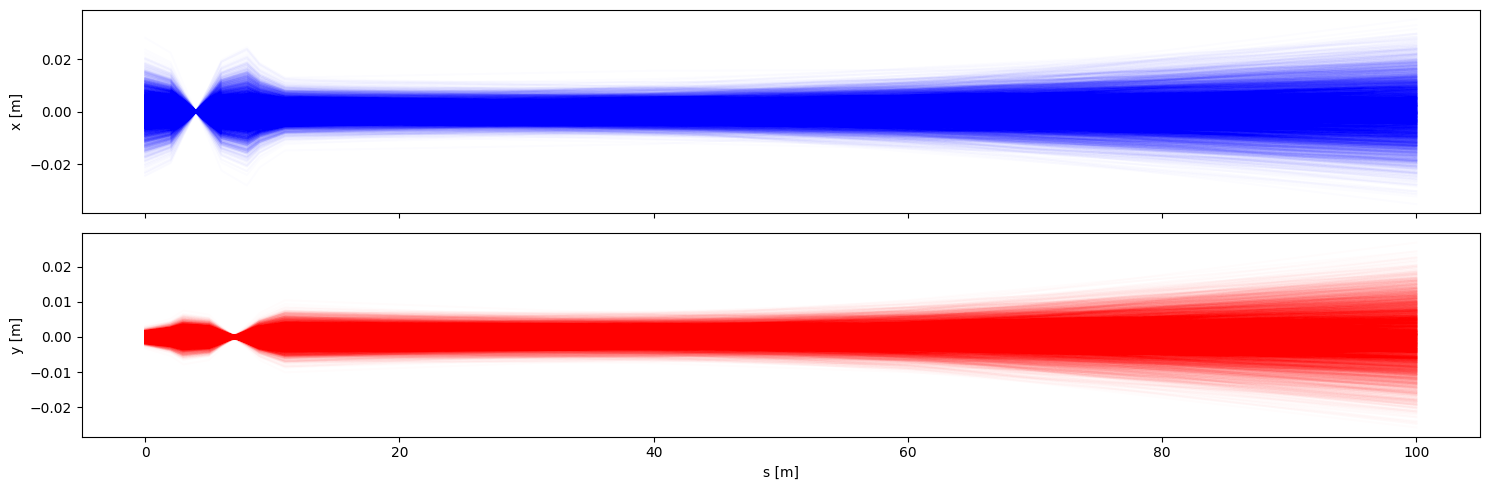

In [14]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax[0].plot(tw.s, line.record_last_track.x[i], color='blue', alpha=0.01);
    ax[1].plot(tw.s, line.record_last_track.y[i], color='red', alpha=0.01);

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

In [15]:
j = 1
print(tw.s[j])
line.record_last_track.x[i][j]

2.0


-0.006037768097562064

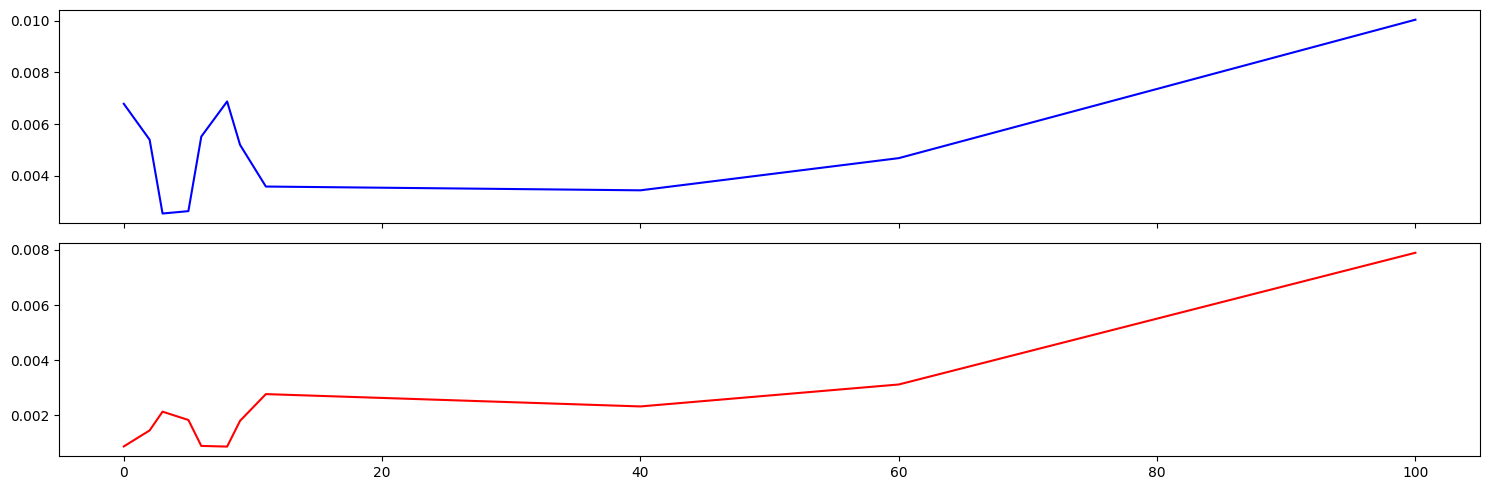

In [16]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

s_list = []
sigH_list = []
sigV_list = []

for i in range(len(tw.s)):
    s_list.append(tw.s[i])
    sigH_list.append(np.std(line.record_last_track.x[:,i]))
    sigV_list.append(np.std(line.record_last_track.y[:,i]))
ax[0].plot(s_list, sigH_list, c="b")
ax[1].plot(s_list, sigV_list, c="r")

import pandas as pd
d = {'s': s_list, 'sigH': sigH_list, 'sigV': sigV_list}
df = pd.DataFrame(data=d)

with open('xsuite_beam_size.p', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)